# Imports and definitions

In [1]:
import torch
import torchvision.transforms.functional as transform
import torchvision.transforms.functional as F
from EnsembleXAI import Ensemble, Metrics
from torchvision.transforms import Resize, CenterCrop
import os
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import urllib.request
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients, Occlusion, NoiseTunnel
from captum.attr import visualization as viz
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
with urllib.request.urlopen("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json") as url:
    imagenet_classes_dict = json.load(url)

In [3]:
def download_class_images(class_id, masks_path):
    full_path = masks_path + class_id + "\\"
    kaggle_path = f"/ILSVRC/Data/CLS-LOC/train/{class_id}/"
    for file_name in os.listdir(full_path):
        file_name_jpeg = file_name[:-3] + 'JPEG'
        !kaggle competitions download -f {kaggle_path}{file_name_jpeg} -p ./images/{class_id}/ -c imagenet-object-localization-challenge


def download():
    skipped = []
    for class_id in os.listdir(masks_dir):
        image_class_path = os.path.join(images_dir, class_id)
        if os.path.exists(image_class_path) and len(os.listdir(image_class_path)) == 10:
            skipped.append(class_id)
            continue
        #download_class_images(class_id, masks_dir)
        print(f"Downloaded {class_id}")
    print("Full dirs: " + str(len(skipped)))


def images_list(image_path, resize=True):
    _crop = CenterCrop(224).forward
    _resize = Resize([232,232]).forward
    images = []
    for image_name in os.listdir(image_path):
        image = Image.open(image_path + image_name)
        if resize:
            image = _crop(_resize(image))
        images.append(image)
    return images

# Images load

In [4]:
input_dir = "\\".join(os.getcwd().split(sep="\\")[:-2] + ['input'])
masks_dir = input_dir + f'\\ImageNetS50\\train-semi-segmentation\\'
images_dir = os.getcwd() + "\\images\\"

In [5]:
print(os.listdir(images_dir))

['n01443537', 'n01491361', 'n01531178', 'n01644373', 'n02104029', 'n02119022', 'n02123597', 'n02133161', 'n02165456', 'n02281406', 'n02325366', 'n02342885', 'n02396427', 'n02483362', 'n02504458', 'n02510455', 'n02690373', 'n02747177', 'n02783161', 'n02814533', 'n02859443', 'n02917067', 'n02992529', 'n03014705', 'n03047690', 'n03095699', 'n03197337', 'n03201208', 'n03445777', 'n03452741', 'n03584829', 'n03630383', 'n03775546', 'n03791053', 'n03874599', 'n03891251', 'n04026417', 'n04335435', 'n04380533', 'n04404412', 'n04447861', 'n04507155', 'n04522168', 'n04557648', 'n04562935', 'n04612504', 'n06794110', 'n07749582', 'n07831146', 'n12998815']


In [6]:
id = "n01491361"
def load_all(classid):
    all_img = images_list(images_dir + classid + "\\")
    all_img_org = images_list(images_dir + classid + "\\", resize=False)
    all_tens = [F.to_tensor(img) for img in all_img]
    all_msks = [(F.to_tensor(img)>0).float() for img in images_list(masks_dir + classid + "\\")]
    tens_img = torch.stack(all_tens)
    tens_msks = torch.stack(all_msks)
    return all_img, all_img_org, all_tens, all_msks, tens_img, tens_msks
all_images, all_images_original, all_tensors, all_masks, tensor_images, tensor_masks = load_all("n01491361")

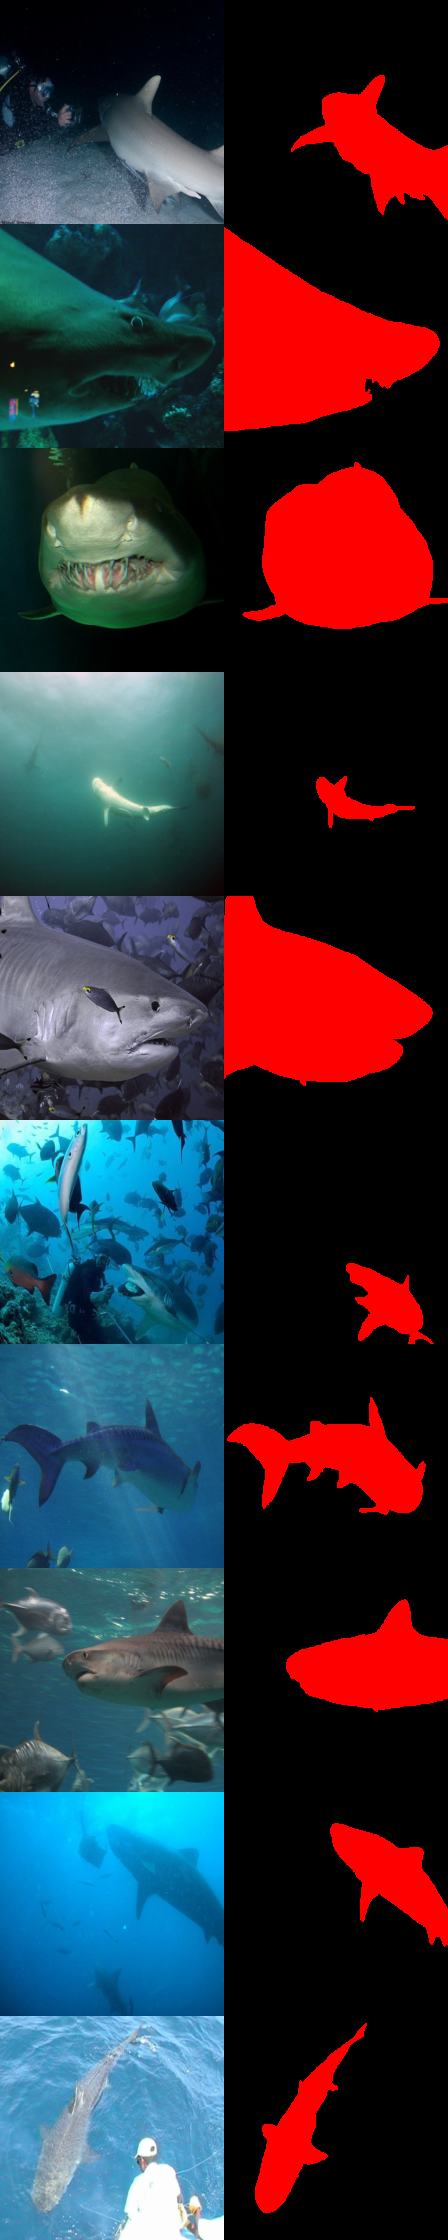

In [7]:
photos = []
for tensor, mask in zip(all_tensors, all_masks):
    photo = torch.cat([tensor, mask], dim=2)
    photos.append(photo)
display(transform.to_pil_image(torch.cat(photos, dim=1)))

# Model Loading

In [8]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.eval()
resnet_transform = ResNet50_Weights.DEFAULT.transforms()
pipeline = lambda images: torch.stack([resnet_transform(image) for image in images])
proper_data = pipeline(all_images_original)

In [9]:
outputs2 = model(proper_data)
_, preds2 = torch.max(outputs2, 1)
probs2 = torch.nn.functional.softmax(outputs2, dim=1)
[imagenet_classes_dict[str(i.item())][1] for i in preds2] # gar = Niszczukokształtne

['tiger_shark',
 'tiger_shark',
 'tiger_shark',
 'great_white_shark',
 'tiger_shark',
 'tiger_shark',
 'tiger_shark',
 'tiger_shark',
 'hammerhead',
 'gar']

# Single Explanations

In [10]:
single_pred = preds2[2].unsqueeze(dim=0)
single_data = proper_data[2].unsqueeze(dim=0)
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(single_data, target=single_pred, n_steps=200)

Basing on: https://captum.ai/tutorials/Resnet_TorchVision_Interpret

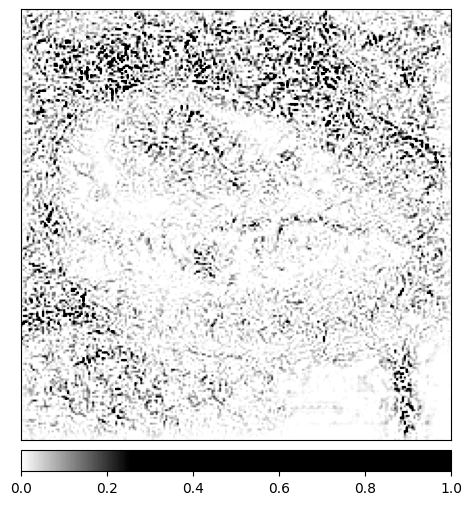

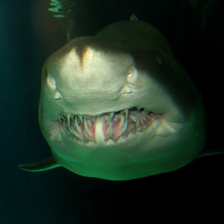

In [11]:
transformed_img = resnet_transform(all_images_original[2])
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
display(all_images[2])

In [12]:
import gc
gc.collect()

159

In [13]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(single_data, nt_samples=5, nt_type='smoothgrad_sq', target=single_pred)

In [14]:
attributions_ig_nt_all = torch.cat([noise_tunnel.attribute(tensor_images[i].unsqueeze(dim=0), nt_samples=5, nt_type='smoothgrad_sq', target=preds2[i].unsqueeze(dim=0)) for i in range(10)], dim=0)

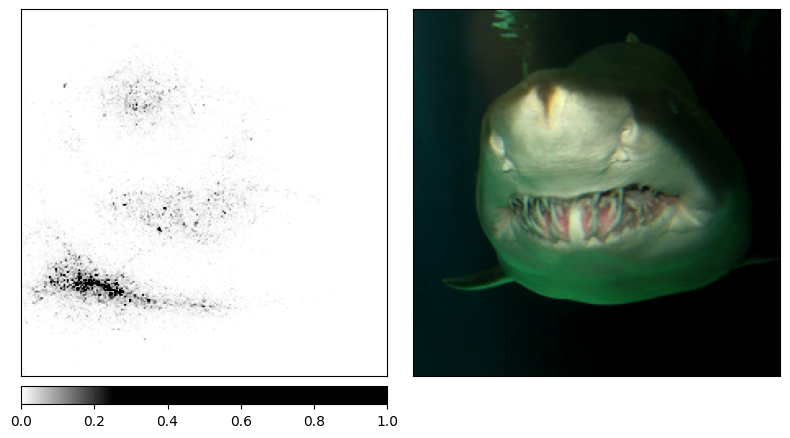

In [15]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["positive", "all"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [16]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(single_data,
                                       strides = (3, 8, 8),
                                       target=single_pred,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

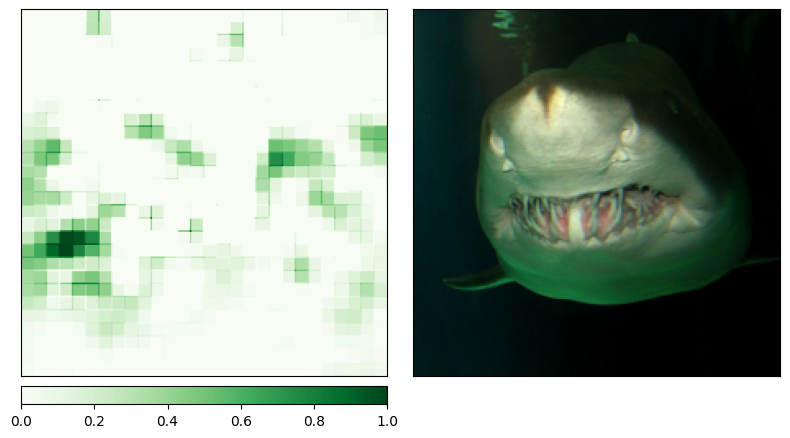

In [17]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["positive", "all"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

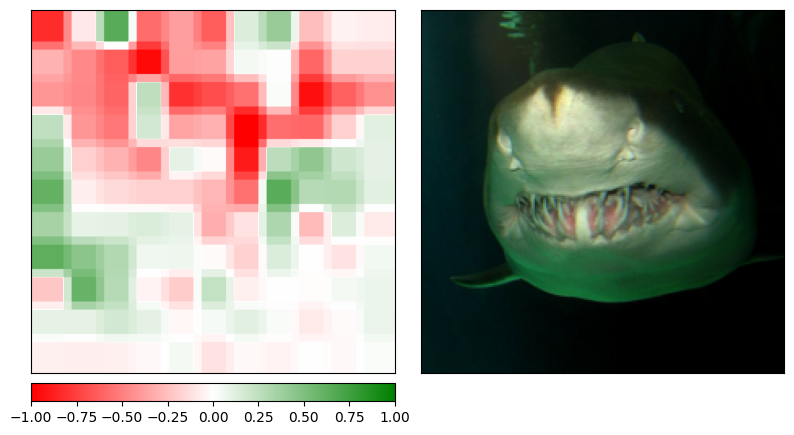

In [18]:
occlusion = Occlusion(model)

attributions_occ2 = occlusion.attribute(single_data,
                                       strides = (3, 20, 20),
                                       target=single_pred,
                                       sliding_window_shapes=(3, 25, 25),
                                       baselines=0)
_2 = viz.visualize_image_attr_multiple(np.transpose(attributions_occ2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

In [19]:
occlusion = Occlusion(model)

attributions_occ_all_25 = occlusion.attribute(tensor_images,
                                        strides = (3, 20, 20),
                                        target = preds2,
                                        sliding_window_shapes = (3, 25, 25),
                                        baselines=0)

attributions_occ_all_15 = occlusion.attribute(tensor_images,
                                           strides = (3, 8, 8),
                                           target = preds2,
                                           sliding_window_shapes = (3, 15, 15),
                                           baselines=0)

In [20]:
Metrics.consistency(attributions_occ_all_25)

0.015270206145942211

In [21]:
Metrics.consistency(torch.cat([attributions_occ, attributions_occ2], dim=0))

0.1005052700638771

In [22]:
predict = lambda x: torch.nn.Softmax(dim=0)(model(x))
Metrics.decision_impact_ratio(tensor_images, predict, attributions_occ_all_25, 0.5, 0)

0.30000001192092896

In [23]:
Metrics.confidence_impact_ratio(tensor_images, predict, attributions_occ_all_25, 0.5, 0)

0.00026409924612380564

In [24]:
Metrics.accordance_recall(attributions_occ_all_25, tensor_masks)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [25]:
Metrics.accordance_precision(attributions_occ_all_25, tensor_masks)

tensor([0.0604, 0.1660, 0.1506, 0.0116, 0.1680, 0.0227, 0.0664, 0.0727, 0.0439,
        0.0397])

In [26]:
Metrics.F1_score(attributions_occ_all_25, tensor_masks)

0.14360663294792175

In [27]:
Metrics.intersection_over_union(attributions_occ_all_25, tensor_masks)

nan

In [28]:
def sample_xai(images):
    if images.shape[0] == 1:
        target = single_pred
    else:
        target = single_pred.repeat(images.shape[0])
    xai = occlusion.attribute(images,
                              strides = (3, 40, 40),
                              target=target,
                              sliding_window_shapes=(3,50, 50),
                              baselines=0)
    return xai
Metrics.stability(sample_xai, single_data.squeeze(dim=0), single_data.repeat(10,1,1,1))

0.0

# Ensembles

In [29]:
x = torch.cat([attributions_occ, attributions_ig_nt])
aggregated1 = Ensemble.aggregate(x, aggregating_func='avg')
aggregated2 = Ensemble.aggregate(x, aggregating_func='min')
aggregated3 = Ensemble.aggregate(x, aggregating_func='max')

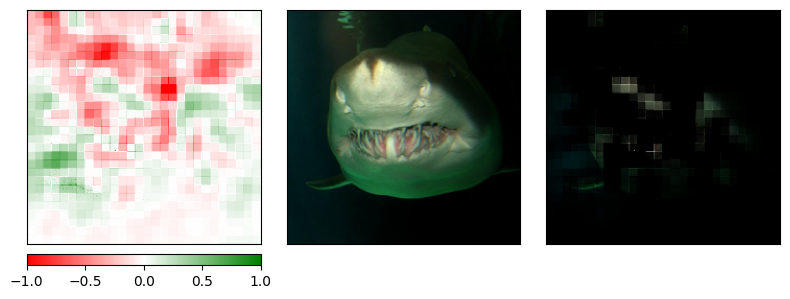

In [30]:
#display(transform.to_pil_image(aggregated1[0]))
_ = viz.visualize_image_attr_multiple(np.transpose(aggregated1.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image", "masked_image"],
                                      ["all", "positive", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

In [31]:
Metrics.accordance_recall(aggregated1, tensor_masks[2].unsqueeze(dim=0)), Metrics.accordance_precision(aggregated1, tensor_masks[2].unsqueeze(dim=0))

(tensor([1.]), tensor([0.1454]))

In [32]:
all_stacked = torch.stack([attributions_ig_nt_all, attributions_occ_all_25], dim=1)

In [33]:
aggreg_all1 = Ensemble.aggregate(all_stacked, aggregating_func='avg')
aggreg_all2 = Ensemble.aggregate(all_stacked, aggregating_func='min')
aggreg_all3 = Ensemble.aggregate(all_stacked, aggregating_func='max')

In [34]:
aggreg_all1.unsqueeze(dim=1).shape

torch.Size([10, 1, 3, 224, 224])

In [35]:
torch.cat([all_stacked, aggreg_all1.unsqueeze(dim=1)], dim=1)

tensor([[[[[ 1.2859e-06,  1.7633e-07,  1.0689e-06,  ...,  8.4889e-07,
             4.1491e-07,  3.3775e-07],
           [ 8.9457e-07,  1.3091e-07,  5.2941e-06,  ...,  6.9748e-08,
             2.4604e-07,  2.9778e-07],
           [ 1.4638e-07,  3.1084e-06,  6.7072e-06,  ...,  3.2731e-06,
             2.1273e-07,  1.5923e-07],
           ...,
           [ 1.6355e-07,  1.3121e-07,  5.8022e-07,  ...,  1.9742e-06,
             1.8559e-08,  4.4192e-08],
           [ 4.9552e-08,  3.8870e-08,  1.7839e-07,  ...,  2.0365e-06,
             1.1894e-06,  6.9667e-08],
           [ 1.4145e-08,  6.5347e-08,  1.4909e-07,  ...,  1.0118e-06,
             7.2725e-07,  9.2535e-08]],

          [[ 1.8178e-07,  4.7097e-07,  8.9923e-07,  ...,  4.5280e-07,
             1.8458e-07,  4.2030e-07],
           [ 4.2285e-07,  3.9496e-07,  9.4336e-07,  ...,  1.4410e-07,
             2.8028e-07,  1.0129e-07],
           [ 6.1348e-07,  3.2520e-07,  5.6160e-07,  ...,  5.7317e-07,
             1.1632e-06,  2.6323e-07],
 

In [36]:
all_stacked.shape

torch.Size([10, 2, 3, 224, 224])

In [37]:
[Metrics.consistency(all_stacked[i]) for i in range(all_stacked.shape[0])]

[0.018643677234649658,
 0.03320879489183426,
 0.046601660549640656,
 0.025091106072068214,
 0.02757113426923752,
 0.031612578779459,
 0.0562540665268898,
 0.048547469079494476,
 0.02579120732843876,
 0.022381847724318504]

In [40]:
plt.style.use('fast')

In [41]:
def plot_explanations(images, explanations, columns_names, classes_predicted, cmaps=[default_cmap, None, None, None, None, None], method = "heat_map"):
    nrow, ncol = len(images), explanations.shape[1]+1
    fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize=(14, 30))
    for col, col_name in zip(ax[0], columns_names):
        col.title.set_text(col_name)
    for i, img in enumerate(images):
        ax[i,0].xaxis.set_ticks_position("none")
        ax[i,0].yaxis.set_ticks_position("none")
        ax[i,0].set_yticklabels([])
        ax[i,0].set_xticklabels([])
        ax[i,0].imshow(np.array(img), vmin=0, vmax=255)
        ax[i,0].set_ylabel(classes_predicted[i], size='large')
        for j, col in enumerate(ax[i,1:]):
            expl = explanations[i,j]
            sign = "positive"
            if expl.amin() < 0:
                sign = "all"
            _ = viz.visualize_image_attr(np.transpose(expl.squeeze().numpy(), (1,2,0)),
                                         original_image=np.array(img),
                                         method=method,
                                         sign=sign,
                                         plt_fig_axis=(fig, col),
                                         show_colorbar=True,
                                         outlier_perc=2,
                                         cmap=cmaps[j],
                                         use_pyplot=False
                                         )
    plt.show()

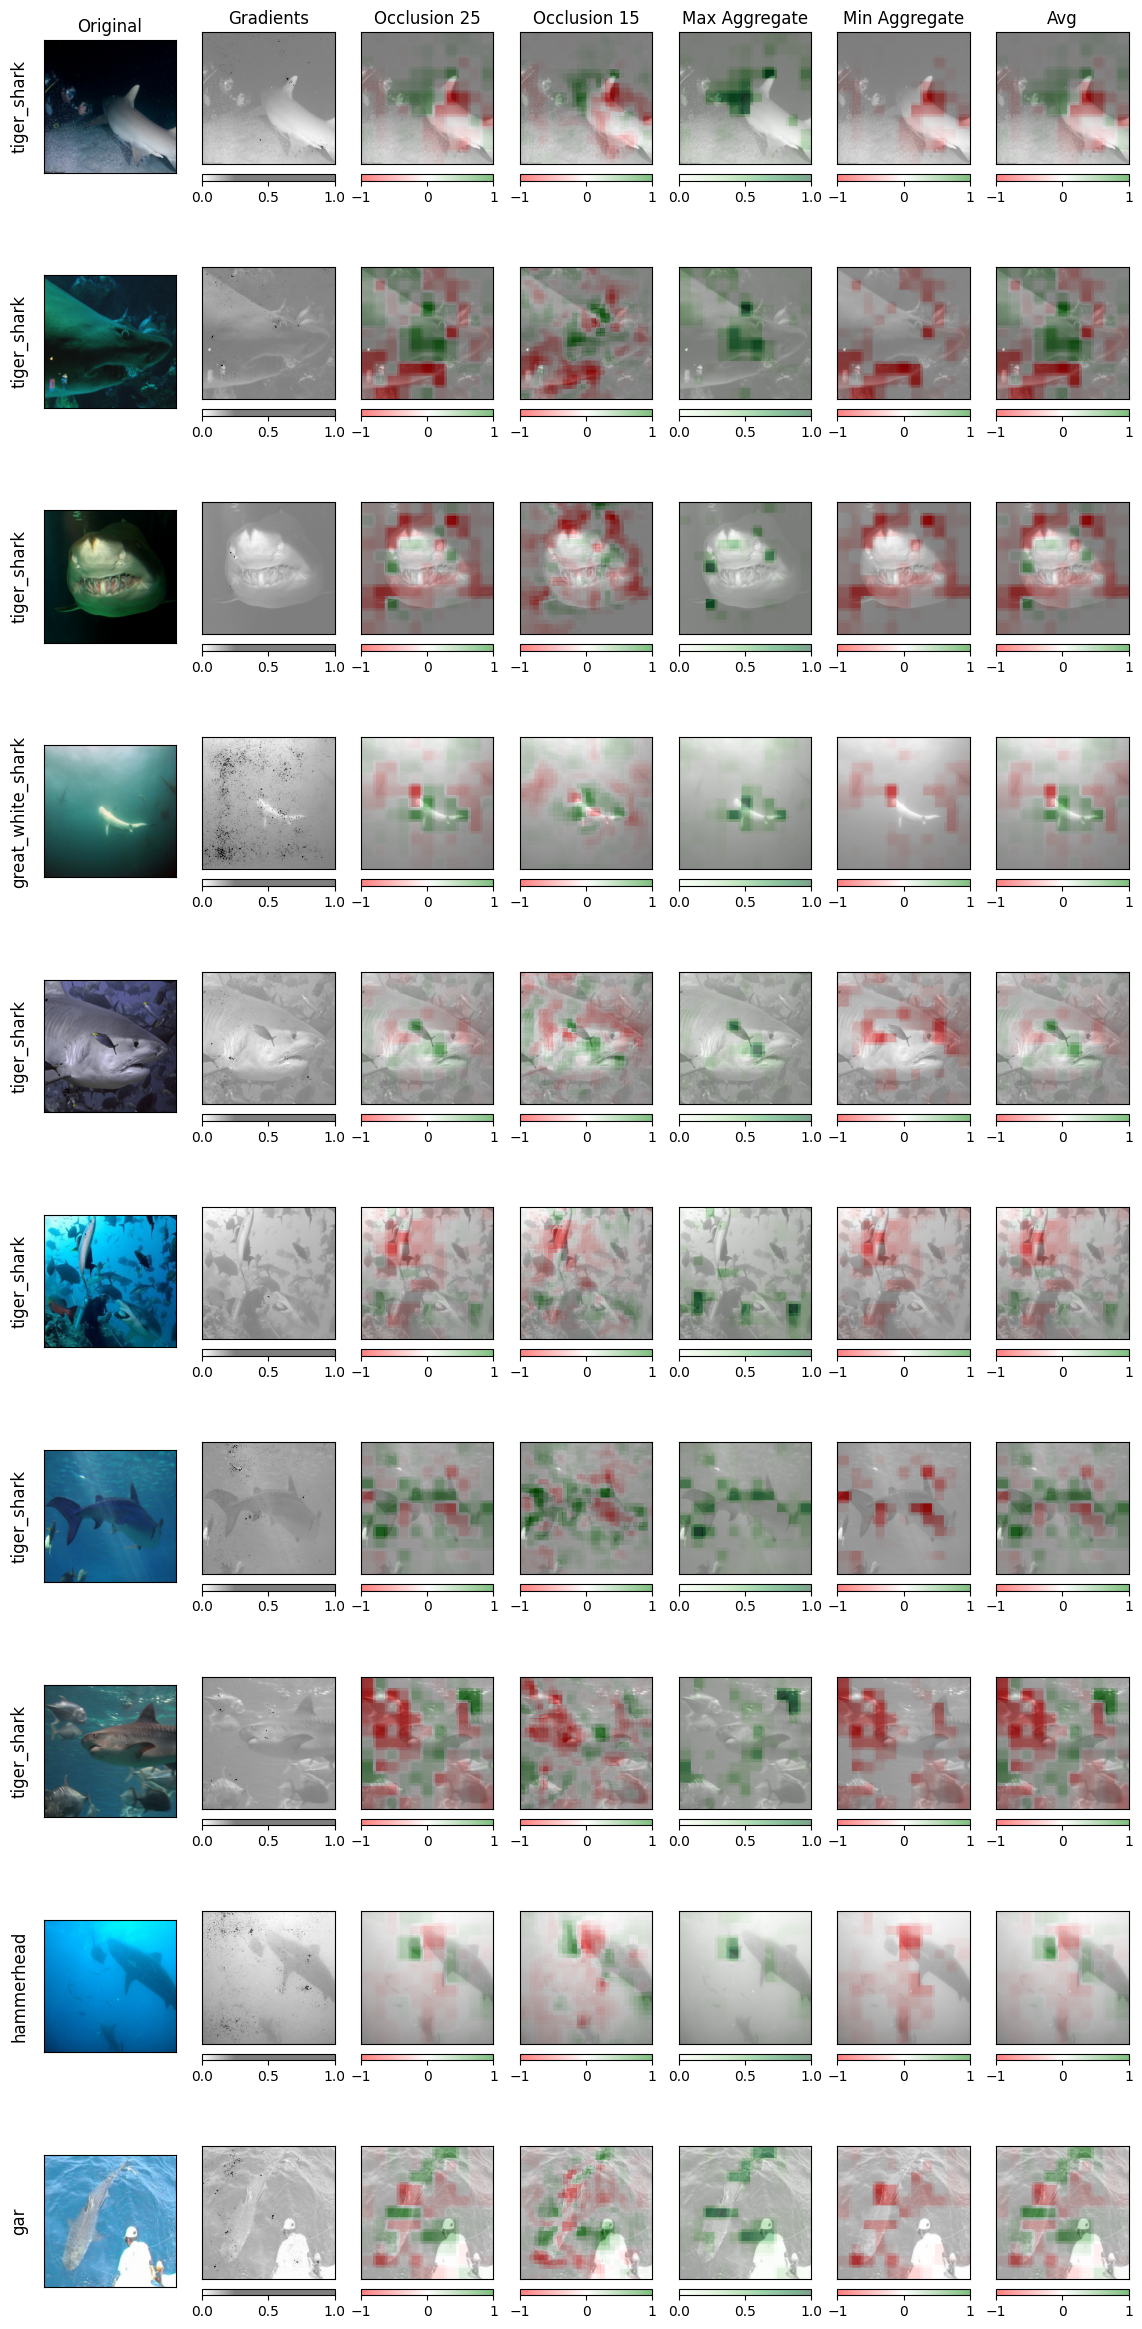

In [42]:
explanations_three = torch.cat([all_stacked, attributions_occ_all_15.unsqueeze(dim=1),aggreg_all3.unsqueeze(dim=1), aggreg_all2.unsqueeze(dim=1), aggreg_all1.unsqueeze(dim=1)], dim=1)
predicted_names = [imagenet_classes_dict[str(i.item())][1] for i in preds2]
col_names = ["Original", "Gradients", "Occlusion 25","Occlusion 15", "Max Aggregate", "Min Aggregate", "Avg"]
plot_explanations(all_images, explanations_three, col_names, predicted_names, method="blended_heat_map")